In [1]:
import argparse
import os
import cv2
import numpy as np
import mmcv
import torch
import json
import PIL
import matplotlib.pyplot as plt
from PIL import ImageGrab
import time
import pyvjoy
import vgamepad as vg
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


from IPython.display import clear_output

from mmdet.models.detectors.condlanenet import CondLanePostProcessor


from mmcv.parallel import MMDataParallel
from mmcv.runner import init_dist, load_checkpoint
from mmdet.datasets import build_dataloader, build_dataset
from mmdet.models import build_detector
from mmdet.utils.general_utils import mkdir, path_join, Timer
from tools.condlanenet.common import tusimple_convert_formal, COLORS
from tools.condlanenet.post_process import CondLanePostProcessor

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

SIZE = (800, 320)

In [2]:
config = '../../configs/condlanenet/tusimple/tusimple_small_test.py'
checkpoint = '../../checkpoints/tusimple_small.pth'
local_rank = 0
imagename = "1200px-Road_in_Norway.jpg"

In [3]:
cfg = mmcv.Config.fromfile(config)
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True
cfg.model.pretrained = None
model = build_detector(cfg.model)
if checkpoint is not None:
    load_checkpoint(model, checkpoint, map_location='cpu')
model = MMDataParallel(model, device_ids=[0])


C:\Users\adama\anaconda3\envs\open-mmlab\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


The model and loaded state dict do not match exactly

unexpected key in source state_dict: bbox_head.reg_branch.0.conv.weight, bbox_head.reg_branch.0.bn.weight, bbox_head.reg_branch.0.bn.bias, bbox_head.reg_branch.0.bn.running_mean, bbox_head.reg_branch.0.bn.running_var, bbox_head.reg_branch.0.bn.num_batches_tracked, bbox_head.reg_branch.1.conv.weight, bbox_head.reg_branch.1.bn.weight, bbox_head.reg_branch.1.bn.bias, bbox_head.reg_branch.1.bn.running_mean, bbox_head.reg_branch.1.bn.running_var, bbox_head.reg_branch.1.bn.num_batches_tracked, bbox_head.reg_branch.2.conv.weight, bbox_head.reg_branch.2.bn.weight, bbox_head.reg_branch.2.bn.bias, bbox_head.reg_branch.2.bn.running_mean, bbox_head.reg_branch.2.bn.running_var, bbox_head.reg_branch.2.bn.num_batches_tracked



In [84]:

#h_samples1 = [240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710]

h_samples1 = list(range(10,240,10))
ori_shape = (800,320)
ori_shape1 = (1640,590-270)
gdiff = np.array([85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85])

In [5]:
def vis_one(results, h_samples, lanes, image, img_info=None, lane_width=7):

    def parse_img_info(h_samples,lanes):
        converted_lanes = []
        #h_samples = img_info['h_samples']
        
        #lanes = img_info['lanes']
        for lane in lanes:
            converted_lane = []
            for coord_x, coord_y in zip(lane, h_samples):
                if coord_x >= 0:
                    converted_lane.append((coord_x, coord_y))
            converted_lanes.append(converted_lane)
        return converted_lanes

    img = image
    img_gt = image
    img_pil = PIL.Image.fromarray(img)
    img_gt_pil = PIL.Image.fromarray(img_gt)
    for idx, lane in enumerate(results):
        lane_tuple = [tuple(p) for p in lane]
        PIL.ImageDraw.Draw(img_pil).line(
            xy=lane_tuple, fill=COLORS[idx + 1], width=lane_width)
    img = np.array(img_pil, dtype=np.uint8)


    gt_lanes = parse_img_info(h_samples,lanes)
    for idx, lane in enumerate(gt_lanes):
        lane_tuple = [tuple(p) for p in lane]
        PIL.ImageDraw.Draw(img_gt_pil).line(
            xy=lane_tuple, fill=COLORS[idx + 1], width=lane_width)
    img_gt = np.array(img_gt_pil, dtype=np.uint8)
    
    return img, img_gt


In [6]:
def adjust_result(lanes, crop_bbox, img_shape):
    h_img, w_img = img_shape[:2]
    #print('h_img '+str(h_img))
    ratio_x = (crop_bbox[2] - crop_bbox[0]) / w_img
    #print('ratio_x '+str(ratio_x))
    ratio_y = (crop_bbox[3] - crop_bbox[1]) / h_img
    #print('ratio_y '+str(ratio_y))
    offset_x, offset_y = crop_bbox[:2]
    #print('offset_x, offset_y '+str(offset_x)+', '+str(offset_y))

    results = []
    if lanes is not None:
        for key in range(len(lanes)):
            pts = []
            for pt in lanes[key]['points']:
                #print(pt[1])
                pt[0] = float(pt[0] * ratio_x + offset_x)
                pt[1] = float(pt[1] * ratio_y + offset_y)
                
                pts.append(tuple(pt))
            if len(pts) > 1:
                results.append(pts)
    return results

In [118]:
def clamp(clampee,minc,maxc):
    if clampee < minc:
        clampee = minc
    if clampee > maxc:
        clampee = maxc
    return clampee

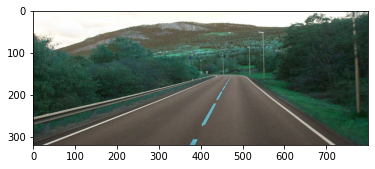

C:\Users\adama\anaconda3\envs\open-mmlab\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


800
[[(405.6384, 144.0), (465.01535, 152.0), (457.82547, 160.0), (451.73404, 168.0), (442.63452, 176.0), (434.92722, 184.0), (428.4399, 192.0), (412.4004, 200.0), (364.08807, 208.0), (306.97144, 216.0), (278.67648, 224.0), (258.98624, 232.0), (238.47064, 240.0), (220.0016, 248.0), (202.2455, 256.0), (180.22864, 264.0), (163.5033, 272.0), (148.95789, 280.0), (122.438644, 288.0), (105.51727, 296.0), (91.96765, 304.0)], [(483.29813, 144.0), (478.98624, 152.0), (471.8085, 160.0), (470.27292, 168.0), (465.88303, 176.0), (462.10733, 184.0), (457.4422, 192.0), (451.5758, 200.0), (446.83627, 208.0), (441.93314, 216.0), (437.46304, 224.0), (431.85962, 232.0), (427.82346, 240.0), (423.44244, 248.0), (418.13293, 256.0), (414.06613, 264.0), (408.4823, 272.0), (402.17966, 280.0), (397.44455, 288.0), (392.74673, 296.0), (387.22714, 304.0), (383.32657, 312.0)], [(497.70325, 144.0), (501.6272, 152.0), (511.4307, 160.0), (520.59845, 168.0), (531.2753, 176.0), (540.57434, 184.0), (549.44183, 192.0), (55

In [7]:
result_dst = 'test'

crop_bbox=(0, 0, 800, 320)
mask_size=(1, 40, 100)
hm_thr=0.3
img = cv2.imread(imagename)
#img = img[270:, ...]
img = cv2.resize(img, (SIZE))
visimg = img
plt.imshow(img)

plt.show()
mean = np.array([75.3, 76.6, 77.6])
std = np.array([50.5, 53.8, 54.3])
img = mmcv.imnormalize(img, mean, std, False)
x = torch.unsqueeze(torch.from_numpy(img).permute(2, 0, 1), 0)
model.eval()
x = x.cuda()
post_processor = CondLanePostProcessor(mask_size=(1, 40, 100), hm_thr=0.5, seg_thr=0.5)





with torch.no_grad():
    seeds, _ = model(x)
    lanes, seeds = post_processor(seeds, downscale = 8)


result = adjust_result(
    lanes=lanes, crop_bbox=crop_bbox, img_shape=(ori_shape[1],ori_shape[0]))
h_img, w_img = SIZE[:2]
print(ori_shape[0])
print(result)


dst_dir = os.path.join(result_dst, 'test.json')
f_dst = open(dst_dir, 'w')
tusimple_lanes = tusimple_convert_formal(
    result, h_samples1, ori_shape[0])
tusimple_sample = dict(
    lanes=tusimple_lanes,
    h_samples=h_samples1,
    raw_file='test',
    run_time=20)
json.dump(tusimple_sample, f_dst)

print(tusimple_sample)

filename = imagename
img_vis, img_gt_vis = vis_one(result, tusimple_sample['h_samples'], tusimple_sample['lanes'], image =visimg)
#save_name = sub_name.replace('/', '.')
#dst_show_dir = path_join(show, save_name)
dst_show_dir = path_join('','gg.jpg')
#dst_show_gt_dir = path_join(show, save_name + '.gt.jpg')
dst_show_gt_dir = path_join('' , 'gt.jpg')
cv2.imwrite(dst_show_dir, img_vis)
cv2.imwrite(dst_show_gt_dir, img_gt_vis)
f_dst.close()



In [8]:

gamepad = vg.VX360Gamepad()

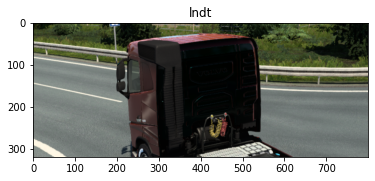

IndexError: list index out of range

In [147]:
#vid_capture = cv2.VideoCapture(0, cv2.CAP_DSHOW)

# Timeout to display frames in seconds
# FPS = 1/TIMEOUT 
# So 1/.025 = 40 FPS
TIMEOUT = .1
old_timestamp = time.time()
took_pic = False

I = 0
frame_width = 920
frame_height = 368
frame_size = (frame_width,frame_height)
output = cv2.VideoWriter('output_video_from_file.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 20, frame_size)
time.sleep(2)
for frame in range(0,300):
    while(True):
        if (time.time() - old_timestamp) > TIMEOUT:
            
            #img_ori = ImageGrab.grab(bbox=(360, 300,1200,480)) #x, y, x_max, y_max
            img_ori = ImageGrab.grab(bbox=(500, 270,1420,638)) #x, y, x_max, y_max

            img_ori1 = ImageGrab.grab(bbox=(1480, 690,1680,890)) #x, y, x_max, y_max
            img1 = np.array(img_ori1)
            img1 = cv2.rectangle(img1, (90, 0), (200, 200), (0, 0, 0), -1)
            img1 = cv2.rectangle(img1, (0, 25), (200, 200), (0, 0, 0), -1)
            
            txt = pytesseract.image_to_string(img1)[:-7]
            try:
                
                if(txt == 'O'):
                    spd = 1
                elif(txt!=[]):
                    spd = int(txt)
            except:
                spd = spd
            
            img = np.array(img_ori)
            #img = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
            result_dst = 'test'

            crop_bbox=(0, 0, 800, 320)
            mask_size=(1, 40, 100)
            hm_thr=0.3
            #img = cv2.imread(imagename)
            #img = img[270:, ...]
            img = cv2.resize(img, (SIZE))
            visimg = img
            #plt.imshow(img)

            #plt.show()
            mean = np.array([75.3, 76.6, 77.6])
            std = np.array([50.5, 53.8, 54.3])
            img = mmcv.imnormalize(img, mean, std, False)
            x = torch.unsqueeze(torch.from_numpy(img).permute(2, 0, 1), 0)
            model.eval()
            x = x.cuda()
            post_processor = CondLanePostProcessor(mask_size=(1, 40, 100), hm_thr=0.5, seg_thr=0.5)





            with torch.no_grad():
                seeds, _ = model(x)
                lanes, seeds = post_processor(seeds, downscale = 8)


            result = adjust_result(
                lanes=lanes, crop_bbox=crop_bbox, img_shape=(ori_shape[1],ori_shape[0]))
            h_img, w_img = SIZE[:2]
            #print(ori_shape[0])
            #print(result)


            dst_dir = os.path.join(result_dst, 'test.json')
            f_dst = open(dst_dir, 'w')
            tusimple_lanes = tusimple_convert_formal(
                result, h_samples1, ori_shape[0])
            tusimple_sample = dict(
                lanes=tusimple_lanes,
                h_samples=h_samples1,
                raw_file='test',
                run_time=20)
            json.dump(tusimple_sample, f_dst)


            filename = imagename
            img_vis, img_gt_vis = vis_one(result, tusimple_sample['h_samples'], tusimple_sample['lanes'], image =visimg)
            #save_name = sub_name.replace('/', '.')
            #dst_show_dir = path_join(show, save_name)
            #dst_show_dir = path_join('','gg.jpg')
            #dst_show_gt_dir = path_join(show, save_name + '.gt.jpg')
            #dst_show_gt_dir = path_join('' , 'gt.jpg')
            #cv2.imwrite(dst_show_dir, img_vis)
            #cv2.imwrite(dst_show_gt_dir, img_gt_vis)
            f_dst.close()

            fps = 20
            old_timestamp = time.time()
            
            output.write(cv2.resize(img_gt_vis, frame_size))
            plt.figure()
            
            plt.imshow(img_gt_vis)
            plt.title('lndt')
            plt.show()
            li = tusimple_sample['lanes']
            closeleft = []
            closeleft_gt = 320
            """for i, lane in enumerate(li):
                li1 = np.array(lane)
                li2 = li1[li1>=0]
                #print(li2)
                if li2.size > 2 and li2[-1] < 400:
                    
                    closeleft.append(li2[-2])
                    #print(li2)
            if closeleft != []:
                ch = max(closeleft) - closeleft_gt
                print(ch)
                I = min(max(I + ch * 0.1,-150),150)
                gamepad.left_joystick(x_value=int(max(min((I + ch)30,3000),-3000)*90/(120+2*spd)), y_value=0) 
                gamepad.update()
            """
            startup = [20000,20000,20000,20000,20000,20000,20000,20000]
            for i, lane in enumerate(li):
                li1 = np.array(lane)
                li2 = li1[li1>=0]
                if li2.size > 4:
                    startup[i] = abs(li2[-1] - 400)
                    
            midlane = startup.index(min(startup))
            #midlane = abs(li - 400).index(min(abs(li - 400)))
            ch = 0 
            li1 = np.array(li[midlane])
            li2 = li1[li1>=0]
            offset = [0]*len(li2)
            offset[-1]=400
            
            for i, p in enumerate(range(0,len(li2)-5)):
                diff1 = li2[-p-3] - li2[-p-1]
                diff2 = li2[-p-5] - li2[-p-3]
                offset[-p-2] = offset[-p-1] + (li2[-p-2] - li2[-p-1])
                offset[-p-3] = offset[-p-2] + (li2[-p-3] - li2[-p-2])
                offset[-p-4] = offset[-p-3] + (li2[-p-4] - li2[-p-3])
                offset[-p-5] = offset[-p-4] + (li2[-p-5] - li2[-p-4])
                offset[-p-6] = offset[-p-5] + (li2[-p-6] - li2[-p-5])
                ch = ch + (diff2 - diff1) * 1 / (1 + 4 * i)
                
            
            t_offset = clamp(-sum(offset - li2 - 85)/2,-500,500)
            if(li2[-1] > 400):
                t_offset = -t_offset
            print('t_offset: ' + str(t_offset))
            print('ch: ' + str(ch))
            print('spd: ' + str(spd))
            gamepad.left_joystick(x_value=int(max(min( t_offset,1000),-1000)*100/(100 + spd * 0.5)), y_value=0) 
            gamepad.update()
            clear_output(wait=True)
            break

gamepad.left_joystick(x_value=0, y_value=0)
gamepad.update()
output.release()


In [37]:

gamepad = vg.VX360Gamepad()
MAX_VJOY = 32767
Dev = pyvjoy.VJoyDevice(1)

def play_function(dev1,X,Y,Z,XRot):
    Dev.data.wAxisX = int(X * 32767)
    Dev.data.wAxisY = int(Y * 32767)
    Dev.data.wAxisZ = int(Z * 32767)
    Dev.data.wAxisXRot = int(XRot * 32767)
    Dev.update()

In [105]:
time.sleep(2)
gamepad.left_joystick(x_value=-1000, y_value=0) 

gamepad.update()
time.sleep(5)
gamepad.left_joystick(x_value=0, y_value=0) 

gamepad.update()

In [90]:
li = tusimple_sample['lanes']
closeleft = []
closeleft_gt = 376
for i, lane in enumerate(li):
    li1 = np.array(lane)
    li2 = li1[li1>=0]
    li2 = li2[li2<=400]
    if li2.size > 0:
        
        closeleft.append(li2[-1])
print(max(closeleft)-376)

0


In [41]:
print(tusimple_sample['lanes'])

[[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 140, 161, 167, 164, 153, 133, 107, 82, 55, 31, 9], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 219, 290, 328, 354, 373, 387, 398, 409, 505, 547, 493], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 172, 212, 240, 255, 259, 256, 250, 242, 233, 223, 212], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 205, 278, 325, 352, 368, 382, 395, 406, 414, 421, 428]]


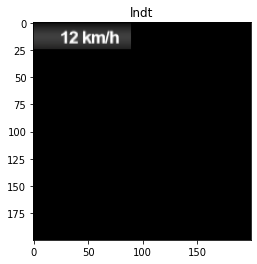

12


In [103]:

img_ori1 = ImageGrab.grab(bbox=(1480, 690,1680,890)) #x, y, x_max, y_max
img1 = np.array(img_ori1)


plt.figure()
img1.size
img1 = cv2.rectangle(img1, (90, 0), (200, 200), (0, 0, 0), -1)
img1 = cv2.rectangle(img1, (0, 25), (200, 200), (0, 0, 0), -1)

plt.imshow(img1)
plt.title('lndt')
plt.show()
txt = pytesseract.image_to_string(img1)[:-7]
if(txt == 'O'):
    spd = 0
elif(txt!=[]):
    spd = int(txt)
print(spd)


In [140]:
startup = [20000,20000,20000,20000,20000,20000,20000,20000]
for i, lane in enumerate(li):
    li1 = np.array(lane)
    li2 = li1[li1>=0]
    if li2.size > 4:
        startup[i] = abs(li2[-1] - 400)

midlane = startup.index(min(startup))
#midlane = abs(li - 400).index(min(abs(li - 400)))
ch = 0 
li1 = np.array(li[midlane])
li2 = li1[li1>=0]
offset = [0]*len(li2)
offset[-1]=400
for i, p in enumerate(range(0,len(li2)-5)):
    diff1 = li2[-p-3] - li2[-p-1]
    diff2 = li2[-p-5] - li2[-p-3]
    offset[-p-2] = offset[-p-1] + (li2[-p-2] - li2[-p-1])
    offset[-p-3] = offset[-p-2] + (li2[-p-3] - li2[-p-2])
    offset[-p-4] = offset[-p-3] + (li2[-p-4] - li2[-p-3])
    offset[-p-5] = offset[-p-4] + (li2[-p-5] - li2[-p-4])
    offset[-p-6] = offset[-p-5] + (li2[-p-6] - li2[-p-5])
    ch = ch + (diff2 - diff1 ) * 1 / (1 + 4 * i)
    print('ch1  : ' + str(diff2 - diff1))

print('ch: ' + str(ch))
print('spd: ' + str(spd))

ch1  : 2
ch1  : 1
ch1  : -1
ch1  : -2
ch1  : 1
ch1  : 3
ch1  : -3
ch: 2.016723407311643
spd: 1


In [141]:
li2

array([392, 389, 384, 376, 367, 360, 353, 345, 337, 329, 322, 315])

In [142]:
offset


[477, 474, 469, 461, 452, 445, 438, 430, 422, 414, 407, 400]